In [1]:
"""
03_visualization.ipynb
Cell 1
Visualization notebook for CaciqueAnalytics.
Charts: dual radar, fan-friendly radar, performance bars, infographic.
Libraries: mplsoccer, matplotlib, PIL
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mplsoccer import Radar
from pathlib import Path
from PIL import Image

PROC_PATH   = Path("../data/processed")
OUTPUT_PATH = Path("../outputs")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

df_2026 = pd.read_csv(PROC_PATH / "primera_division_2026_processed.csv")
df_2025 = pd.read_csv(PROC_PATH / "primera_division_2025_processed.csv")

print(f"2026 -> {df_2026.shape}")
print(f"2025 -> {df_2025.shape}")

2026 -> (237, 88)
2025 -> (416, 88)


In [2]:
"""
Cell 2
Global palette, position labels, and metric sets used across all chart functions.
INVERT_COLS: metrics where a lower value means better performance.
PCT_COLS: percentage metrics rounded to integer for display.
"""
THEME = {
    "bg":     "#0E1117",
    "ring":   "#1C2333",
    "edge":   "#2E3A50",
    "p1":     "#4CA3DD",
    "p2":     "#E05A4E",
    "avg":    "#A0A8B8",
    "label":  "#FFFFFF",
    "range":  "#C8D0DC",
    "credit": "#6B7A90",
    "gold":   "#F5C518",
    "green":  "#4CAF50",
    "red":    "#E05A4E",
}

POSITION_ES = {
    "Forwards":    "Delanteros",
    "Midfielders": "Mediocampistas",
    "Defenders":   "Defensores",
    "Goalkeepers": "Porteros",
}

INVERT_COLS = {
    "foulsCommitted_p90",
    "offsides_p90",
    "goalsConcededInsideTheBox_p90",
    "dribbledPast_p90",
}

PCT_COLS = {
    "goalConversionPercentage",
    "accuratePassesPercentage",
    "accurateCrossesPercentage",
    "accurateLongBallsPercentage",
    "totalDuelsWonPercentage",
    "aerialDuelsWonPercentage",
    "groundDuelsWonPercentage",
}

In [3]:
"""
Cell 3
Metric sets per position used for radar chart axes.
Reduced to 6 metrics for social media readability.
METRIC_DESCRIPTIONS_ES: Spanish display labels mapped to internal column names.
"""
RADAR_METRICS = {
    "Forwards": [
        "goals_p90",
        "totalShots_p90",
        "goalConversionPercentage",
        "successfulDribbles_p90",
        "assists_p90",
        "bigChancesMissed_p90",
    ],
    "Midfielders": [
        "accuratePassesPercentage",
        "keyPasses_p90",
        "bigChancesCreated_p90",
        "assists_p90",
        "interceptions_p90",
        "successfulDribbles_p90",
    ],
    "Defenders": [
        "groundDuelsWon_p90",
        "interceptions_p90",
        "clearances_p90",
        "aerialDuelsWonPercentage",
        "accuratePassesPercentage",
        "successfulDribbles_p90",
    ],
    "Goalkeepers": [
        "saves_p90",
        "savedShotsFromInsideTheBox_p90",
        "goalsConcededInsideTheBox_p90",
        "highClaims_p90",
        "successfulRunsOut_p90",
        "accuratePassesPercentage",
    ],
}

METRIC_DESCRIPTIONS_ES = {
    # Scoring
    "goals_p90":                       "Goles p/90'",
    "goalConversionPercentage":        "Conversion %",
    "bigChancesMissed_p90":            "Chances\nfalladas p/90' (v)",
    # Shooting
    "totalShots_p90":                  "Tiros p/90'",
    "shotsOnTarget_p90":               "Tiros al arco p/90'",
    # Creativity
    "bigChancesCreated_p90":           "Grandes chances\ncreadas p/90'",
    "assists_p90":                     "Asistencias p/90'",
    "keyPasses_p90":                   "Pases clave p/90'",
    # Passing
    "accuratePassesPercentage":        "Precision\nde pase %",
    "accurateLongBallsPercentage":     "Pelotas largas\nprecisas %",
    "accurateCrossesPercentage":       "Centros\nprecisos %",
    # Duels
    "totalDuelsWonPercentage":         "Duelos\nganados %",
    "aerialDuelsWonPercentage":        "Duelos aereos\nganados %",
    "groundDuelsWonPercentage":        "Duelos en piso\nganados %",
    "groundDuelsWon_p90":              "Duelos en suelo\nganados p/90'",
    # Dribbling
    "successfulDribbles_p90":          "Regates\nexitosos p/90'",
    # Defending
    "tackles_p90":                     "Entradas p/90'",
    "interceptions_p90":               "Intercepciones\np/90'",
    "clearances_p90":                  "Despejes\np/90'",
    "blockedShots_p90":                "Tiros\nbloqueados p/90'",
    "dribbledPast_p90":                "Veces regateado p/90' (v)",
    # Discipline
    "foulsCommitted_p90":              "Faltas\ncometidas p/90' (v)",
    "wasFouled_p90":                   "Faltas\nrecibidas p/90'",
    "offsides_p90":                    "Fueras de\njuego p/90' (v)",
    # Goalkeeping
    "saves_p90":                       "Atajadas p/90'",
    "savedShotsFromInsideTheBox_p90":  "Paradas dentro\ndel area p/90'",
    "goalsConcededInsideTheBox_p90":   "Goles recibidos\ndentro del area (v)",
    "highClaims_p90":                  "Salidas aereas p/90'",
    "successfulRunsOut_p90":           "Salidas exitosas p/90'",
}

print("Metrics and labels defined.")

Metrics and labels defined.


In [4]:
"""
Cell 4
Utility functions shared across all chart builders.
  get_player   : returns a player row; prints suggestions if not found.
  _fmt         : formats a metric value (int for PCT_COLS, 2 decimals otherwise).
  _get_scale   : computes p5, p95, and median lists for radar scaling.
  _invert      : inverts lower-is-better metrics so the outer ring always means better.
  _get_pool    : returns the combined position pool from both seasons.
  _save        : saves a figure with dark or transparent background.
"""

def get_player(df: pd.DataFrame, name: str) -> pd.Series | None:
    result = df[df["player"].str.lower() == name.lower()]
    if result.empty:
        print(f"Player not found: {name}")
        similar = df[df["player"].str.lower().str.contains(
            name.lower().split()[0], na=False)]["player"].values
        print(f"Similar names: {similar}")
        return None
    return result.iloc[0]


def _fmt(val, metric: str):
    return int(round(val)) if metric in PCT_COLS else round(float(val), 2)


def _get_scale(pool: pd.DataFrame, metrics: list):
    low    = [_fmt(pool[m].quantile(0.05), m) for m in metrics]
    high   = [_fmt(pool[m].quantile(0.95), m) for m in metrics]
    median = [_fmt(pool[m].median(),        m) for m in metrics]
    return low, high, median


def _invert(metrics: list, low: list, high: list, *val_lists):
    for i, m in enumerate(metrics):
        if m in INVERT_COLS:
            lo, hi = low[i], high[i]
            for lst in val_lists:
                lst[i] = round(lo + hi - lst[i], 2)


def _get_pool(position: str) -> pd.DataFrame:
    return pd.concat([
        df_2026[df_2026["position"] == position],
        df_2025[df_2025["position"] == position],
    ])


def _save(fig, filename: str, transparent: bool = False):
    fc  = "none" if transparent else fig.get_facecolor()
    out = OUTPUT_PATH / filename
    fig.savefig(out, dpi=150, bbox_inches="tight",
                facecolor=fc, transparent=transparent)
    print(f"Saved -> outputs/{filename}")


# Smoke test
print(get_player(df_2026, "Fernando Zampedri")[
    ["player", "team", "goals", "goals_p90", "minutesPlayed"]
])

player              Fernando Zampedri
team             Universidad Católica
goals                               6
goals_p90                         1.5
minutesPlayed                     360
Name: 196, dtype: object


In [5]:
"""
Cell 5
Builds a dual-player radar chart with a dark theme for social media publishing.
Scale based on p5-p95 of the position pool across both seasons.
A dashed league median polygon serves as the visual reference baseline.
Metrics where lower = better are inverted so the outer ring always means better.
Use minimal=True to export only the radar polygon (no header/legend/footer)
for compositing in external tools like Photopea.
"""

def build_radar(player1_name: str, season1: str,
                player2_name: str, season2: str,
                position: str,
                minimal: bool = False) -> None:

    df1 = df_2026 if season1 == "2026" else df_2025
    df2 = df_2026 if season2 == "2026" else df_2025

    p1 = get_player(df1, player1_name)
    p2 = get_player(df2, player2_name)
    if p1 is None or p2 is None:
        return

    metrics = RADAR_METRICS[position]
    pool    = _get_pool(position)
    low, high, median = _get_scale(pool, metrics)

    vals1 = [_fmt(p1[m], m) for m in metrics]
    vals2 = [_fmt(p2[m], m) for m in metrics]

    _invert(metrics, low, high, vals1, vals2, median)

    labels = [METRIC_DESCRIPTIONS_ES.get(m, m) for m in metrics]
    T = THEME

    radar = Radar(labels, low, high, num_rings=4, ring_width=1, center_circle_radius=1)
    fig, ax = radar.setup_axis()
    fig.set_facecolor(T["bg"])
    ax.set_facecolor(T["bg"])

    radar.draw_circles(ax=ax, facecolor=T["ring"], edgecolor=T["edge"], lw=1)
    radar.draw_range_labels(ax=ax, fontsize=9, color=T["range"], fontweight="bold")
    radar.draw_radar_compare(
        vals1, vals2, ax=ax,
        kwargs_radar=  {"facecolor": T["p1"], "alpha": 0.45},
        kwargs_compare={"facecolor": T["p2"], "alpha": 0.45},
    )
    radar.draw_radar_solid(median, ax=ax, kwargs={
        "facecolor": "none", "edgecolor": T["avg"],
        "linewidth": 1.8, "linestyle": "--", "alpha": 0.9,
    })
    radar.draw_param_labels(ax=ax, fontsize=11, color=T["label"], fontweight="bold")

    if not minimal:
        title = player1_name if player1_name == player2_name \
                else f"{player1_name} vs {player2_name}"
        fig.text(0.5, 0.97, title, color=T["label"], fontsize=15,
                 fontweight="bold", ha="center", va="top",
                 transform=fig.transFigure)

        fig.text(0.497, 0.93, season1, ha="right", va="top", fontsize=12,
                 fontweight="bold", color=T["p1"], transform=fig.transFigure)
        fig.text(0.500, 0.93, "-", ha="center", va="top", fontsize=12,
                 fontweight="bold", color=T["avg"], transform=fig.transFigure)
        fig.text(0.503, 0.93, season2, ha="left", va="top", fontsize=12,
                 fontweight="bold", color=T["p2"], transform=fig.transFigure)

        pos_es = POSITION_ES.get(position, position)
        fig.text(0.5, 0.90, f"Estadisticas por 90' - {pos_es}",
                 color=T["avg"], fontsize=10, ha="center", style="italic",
                 transform=fig.transFigure)

        legend_elements = [
            Patch(facecolor=T["p1"], alpha=0.6, label=f"{player1_name} {season1}"),
            Patch(facecolor=T["p2"], alpha=0.6, label=f"{player2_name} {season2}"),
            Line2D([0], [0], color=T["avg"], linewidth=2, linestyle="--",
                   label=f"Promedio {pos_es.lower()} liga"),
        ]
        legend = ax.legend(handles=legend_elements, loc="lower center",
                           bbox_to_anchor=(0.5, -0.18), ncol=3,
                           frameon=False, fontsize=9, labelcolor=T["label"])
        for text in legend.get_texts():
            text.set_fontweight("bold")

        fig.text(0.5, 0.02, "CaciqueAnalytics | Datos: SofaScore",
                 color=T["credit"], fontsize=9, ha="center")

    base     = (f"{player1_name.replace(' ', '_')}_{season1}"
                f"_vs_{player2_name.replace(' ', '_')}_{season2}")
    suffix   = "_minimal" if minimal else ""
    filename = f"{base}{suffix}.png"

    _save(fig, filename)
    _save(fig, filename.replace(".png", "_transparent.png"), transparent=True)
    plt.show()

In [6]:
"""
Cell 6
Builds a single-player radar chart compared against the league median.
Designed for fans: no jargon, single visual reference baseline.
Gray fill = league average. Blue fill = player.
Use minimal=True for Canva/Photopea compositing (no header/footer).
"""

def build_radar_fan_friendly(player_name: str, season: str, position: str,
                             minimal: bool = True) -> None:

    df   = df_2026 if season == "2026" else df_2025
    p    = get_player(df, player_name)
    if p is None:
        return

    metrics = RADAR_METRICS[position]
    pool    = _get_pool(position)
    low, high, median = _get_scale(pool, metrics)

    vals = [_fmt(p[m], m) for m in metrics]
    _invert(metrics, low, high, vals, median)

    labels = [METRIC_DESCRIPTIONS_ES.get(m, m) for m in metrics]
    T = THEME

    radar = Radar(labels, low, high, num_rings=4, ring_width=1, center_circle_radius=1)
    fig, ax = radar.setup_axis()
    fig.set_facecolor(T["bg"])
    ax.set_facecolor(T["bg"])

    radar.draw_circles(ax=ax, facecolor=T["ring"], edgecolor=T["edge"], lw=1)
    radar.draw_range_labels(ax=ax, fontsize=9, color=T["range"], fontweight="bold")
    radar.draw_radar_solid(median, ax=ax, kwargs={
        "facecolor": T["avg"], "alpha": 0.18,
        "edgecolor": T["avg"], "linewidth": 1.3, "linestyle": "--",
    })
    radar.draw_radar_solid(vals, ax=ax, kwargs={
        "facecolor": T["p1"], "alpha": 0.40,
        "edgecolor": T["p1"], "linewidth": 2.0,
    })
    radar.draw_param_labels(ax=ax, fontsize=11, color=T["label"], fontweight="bold")

    pos_es = POSITION_ES.get(position, position)
    if not minimal:
        fig.text(0.5, 0.97, player_name, color=T["label"], fontsize=15,
                 fontweight="bold", ha="center", va="top",
                 transform=fig.transFigure)
        fig.text(0.5, 0.93, f"{pos_es} - Temporada {season}",
                 color=T["avg"], fontsize=11, ha="center", va="top",
                 transform=fig.transFigure)
        fig.text(0.5, 0.07,
                 "Zona gris = jugador promedio liga   Zona azul = este jugador",
                 color=T["avg"], fontsize=9, ha="center",
                 transform=fig.transFigure)
        fig.text(0.5, 0.03, "CaciqueAnalytics | Datos: SofaScore",
                 color=T["credit"], fontsize=9, ha="center",
                 transform=fig.transFigure)
    else:
        fig.text(0.5, 0.05,
                 "Mas hacia afuera = mejor   Gris = promedio liga   Azul = jugador",
                 color=T["avg"], fontsize=9, ha="center",
                 transform=fig.transFigure)

    base     = f"{player_name.replace(' ', '_')}_{season}_radar_fans"
    filename = f"{base}.png"
    _save(fig, filename)
    _save(fig, filename.replace(".png", "_transparent.png"), transparent=True)
    plt.show()

In [7]:
"""
Cell 7
Builds a horizontal percentile bar chart with a dark theme.
Bars show each stat's percentile rank vs the position pool.
Green = above median, Red = below median.
Exports both a dark-background and a transparent version.

stats parameter format: list of (column, label, unit, is_percentage)
Example:
    STATS_DEFENDERS = [
        ("aerialDuelsWonPercentage", "Duelos aereos ganados", "%",     True),
        ("groundDuelsWon_p90",       "Duelos suelo ganados",  "p/90'", False),
        ("interceptions_p90",        "Intercepciones",        "p/90'", False),
        ("accuratePassesPercentage", "Precision de pase",     "%",     True),
    ]
"""

def build_performance_bars(player_name: str, season: str,
                           position: str, stats: list) -> None:

    df     = df_2026 if season == "2026" else df_2025
    player = get_player(df, player_name)
    if player is None:
        return

    pool = _get_pool(position)
    T    = THEME

    fig, ax = plt.subplots(figsize=(9, 7), dpi=150)
    ax.set_facecolor(T["bg"])
    fig.set_facecolor(T["bg"])
    ax.axis("off")

    ax.text(0.5, 0.95, player_name, color=T["label"], fontsize=20,
            fontweight="bold", ha="center", va="top", transform=ax.transAxes)
    ax.text(0.5, 0.90, f"{season}  {POSITION_ES.get(position, position)}",
            color=T["avg"], fontsize=11, ha="center", va="top",
            transform=ax.transAxes)

    n     = len(stats)
    y_pos = np.linspace(0.80, 0.15, n)

    for (col, label, unit, is_pct), y in zip(stats, y_pos):
        raw_val   = player[col]
        val_str   = f"{int(round(raw_val))}%" if is_pct else f"{round(raw_val, 2)}"
        pct_rank  = float((pool[col] < raw_val).mean())
        med       = float(pool[col].median())
        color_bar = T["green"] if raw_val >= med else T["red"]

        if pct_rank >= 0.80:
            rank_text = f"Top {100 - int(pct_rank * 100)}% liga"
        elif pct_rank >= 0.60:
            rank_text = "Sobre la media"
        elif pct_rank >= 0.40:
            rank_text = "En la media"
        else:
            rank_text = "Bajo la media"

        ax.text(0.05, y,        val_str, color=T["gold"], fontsize=16,
                fontweight="bold", ha="left", va="center",
                transform=ax.transAxes)
        ax.text(0.05, y - 0.035, label,  color=T["label"], fontsize=9,
                ha="left", va="center", transform=ax.transAxes)

        bar_x, bar_w, bar_h = 0.35, 0.45, 0.04

        ax.add_patch(mpatches.FancyBboxPatch(
            (bar_x, y - bar_h / 2), bar_w, bar_h,
            boxstyle="round,pad=0.003", linewidth=0,
            facecolor=T["ring"], transform=ax.transAxes, clip_on=False,
        ))
        ax.add_patch(mpatches.FancyBboxPatch(
            (bar_x, y - bar_h / 2), bar_w * pct_rank, bar_h,
            boxstyle="round,pad=0.003", linewidth=0,
            facecolor=color_bar, alpha=0.9,
            transform=ax.transAxes, clip_on=False,
        ))
        ax.text(0.84, y, rank_text, color=T["avg"], fontsize=9,
                ha="left", va="center", transform=ax.transAxes)

    ax.text(0.5, 0.06,
            "Verde = sobre media liga   |   Rojo = bajo media liga",
            color=T["avg"], fontsize=9, ha="center",
            transform=ax.transAxes, style="italic")
    ax.text(0.5, 0.02, "CaciqueAnalytics | Datos: SofaScore",
            color=T["credit"], fontsize=9, ha="center",
            transform=ax.transAxes)

    filename = f"{player_name.replace(' ', '_')}_{season}_bars.png"
    _save(fig, filename)
    _save(fig, filename.replace(".png", "_transparent.png"), transparent=True)
    plt.show()

In [8]:
"""
Cell 8
Builds a photo + percentile bars infographic. 1080x1080px at 150dpi.
Left panel: player photo. Right panel: key stats with percentile bars.
Exports a dark-background version only (compose transparency in Canva/Photopea).

stats parameter format: list of (column, label, unit, is_percentage)
"""

def build_infographic(player_name: str, season: str,
                      position: str, photo_path: str,
                      stats: list) -> None:

    df     = df_2026 if season == "2026" else df_2025
    player = get_player(df, player_name)
    if player is None:
        return

    pool = _get_pool(position)
    T    = THEME

    fig = plt.figure(figsize=(10.8, 10.8), facecolor=T["bg"])
    gs  = gridspec.GridSpec(
        1, 2, figure=fig,
        left=0.03, right=0.97, top=0.88, bottom=0.06,
        wspace=0.06, width_ratios=[1, 1.4],
    )
    ax_photo = fig.add_subplot(gs[0, 0])
    ax_stats = fig.add_subplot(gs[0, 1])

    for ax in [ax_photo, ax_stats]:
        ax.set_facecolor(T["bg"])
        ax.axis("off")

    # Player photo
    try:
        img = Image.open(photo_path)
        ax_photo.imshow(img, aspect="equal")
        ax_photo.set_xlim(0, img.width)
        ax_photo.set_ylim(img.height, 0)
    except Exception:
        ax_photo.text(0.5, 0.5, "Photo not found", color=T["avg"],
                      ha="center", va="center", transform=ax_photo.transAxes)

    # Stats panel
    n      = len(stats)
    y_step = 1.0 / n

    for i, (col, label, unit, is_pct) in enumerate(stats):
        y_center = 1.0 - (i + 0.5) * y_step
        raw_val  = player[col]
        val_str  = f"{int(round(raw_val))}%" if is_pct else f"{round(raw_val, 2)}"
        pct_rank = float((pool[col] < raw_val).mean())

        ax_stats.text(0.02, y_center + 0.045, val_str,
                      color=T["gold"], fontsize=28, fontweight="bold",
                      va="center", transform=ax_stats.transAxes)
        ax_stats.text(0.02 + (0.13 if is_pct else 0.17), y_center + 0.048,
                      unit, color=T["avg"], fontsize=10,
                      va="center", transform=ax_stats.transAxes)
        ax_stats.text(0.02, y_center - 0.005, label,
                      color=T["label"], fontsize=9, fontweight="bold",
                      va="center", transform=ax_stats.transAxes)

        ax_stats.add_patch(mpatches.FancyBboxPatch(
            (0.02, y_center - 0.055), 0.92, 0.022,
            boxstyle="round,pad=0.002", linewidth=0, facecolor=T["ring"],
            transform=ax_stats.transAxes, clip_on=False,
        ))
        ax_stats.add_patch(mpatches.FancyBboxPatch(
            (0.02, y_center - 0.055), 0.92 * pct_rank, 0.022,
            boxstyle="round,pad=0.002", linewidth=0,
            facecolor=T["p1"], alpha=0.85,
            transform=ax_stats.transAxes, clip_on=False,
        ))
        ax_stats.text(0.02 + 0.92 + 0.01, y_center - 0.055 + 0.011,
                      f"P{int(pct_rank * 100)}", color=T["avg"], fontsize=8,
                      va="center", transform=ax_stats.transAxes)

        if i < n - 1:
            ax_stats.plot([0.02, 0.98],
                          [y_center - y_step * 0.45, y_center - y_step * 0.45],
                          color=T["edge"], linewidth=0.6,
                          transform=ax_stats.transAxes)

    # Header
    pos_es = POSITION_ES.get(position, position)
    fig.text(0.05, 0.95, player_name,
             color=T["label"], fontsize=22, fontweight="bold", va="top")
    fig.text(0.05, 0.91, f"Colo-Colo  Season {season}  {pos_es}",
             color=T["avg"], fontsize=11, va="top")
    fig.add_artist(plt.Line2D(
        [0.05, 0.95], [0.895, 0.895],
        color=T["p1"], linewidth=1.5, transform=fig.transFigure,
    ))
    fig.text(0.55, 0.91, "<- Percentile vs league (same position)",
             color=T["credit"], fontsize=8, va="top", style="italic")

    # Footer
    fig.text(0.05, 0.035, "CaciqueAnalytics",
             color=T["p1"], fontsize=10, fontweight="bold")
    fig.text(0.27, 0.035, "| Datos: SofaScore",
             color=T["credit"], fontsize=10)

    filename = f"{player_name.replace(' ', '_')}_{season}_infographic.png"
    _save(fig, filename)
    plt.show()

In [ ]:
"""
Cell 9
Returns a DataFrame comparing a player's metric values against
league percentiles (p5, p50, p95) for their position.
Useful for validating radar chart inputs before publishing.
"""

def debug_player_stats(player_name: str, season: str, position: str) -> pd.DataFrame:
    df   = df_2026 if season == "2026" else df_2025
    p    = get_player(df, player_name)
    pool = _get_pool(position)

    rows = []
    for m in RADAR_METRICS[position]:
        rows.append({
            "Metric":   METRIC_DESCRIPTIONS_ES.get(m, m).replace("\n", " "),
            "Player":   float(p[m]),
            "Lge p50":  float(pool[m].median()),
            "Lge p05":  float(pool[m].quantile(0.05)),
            "Lge p95":  float(pool[m].quantile(0.95)),
        })
    return pd.DataFrame(rows)


debug_player_stats("Jeyson Rojas", "2026", "Defenders")

,Metric,Player,Lge p50,Lge p05,Lge p95
0,Duelos en suelo ganados p/90',3.673,2.765,0.9184,4.9454
1,Intercepciones p/90',1.224,1.024,0.2500,2.0642
2,Despejes p/90',3.367,4.231,1.5952,8.1836
3,Duelos aereos ganados %,71.430,55.380,0.0000,75.5740
4,Precision de pase %,80.880,80.490,66.8600,89.7500
5,Regates exitosos p/90',0.306,0.307,0.0000,1.4708


Saved -> outputs/Jeyson_Rojas_2025_vs_Jeyson_Rojas_2026.png
Saved -> outputs/Jeyson_Rojas_2025_vs_Jeyson_Rojas_2026_transparent.png


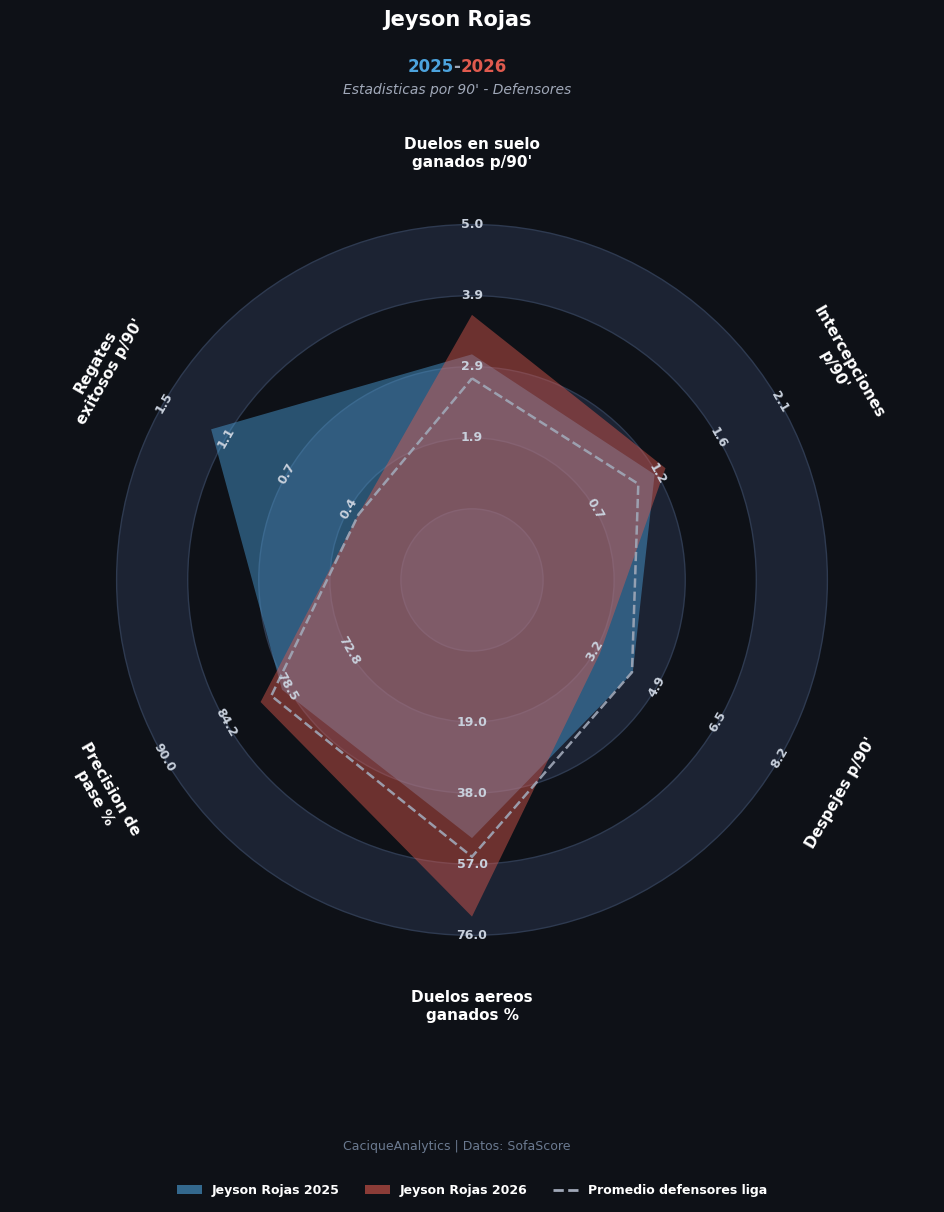

Saved -> outputs/Jeyson_Rojas_2025_vs_Jeyson_Rojas_2026_minimal.png
Saved -> outputs/Jeyson_Rojas_2025_vs_Jeyson_Rojas_2026_minimal_transparent.png


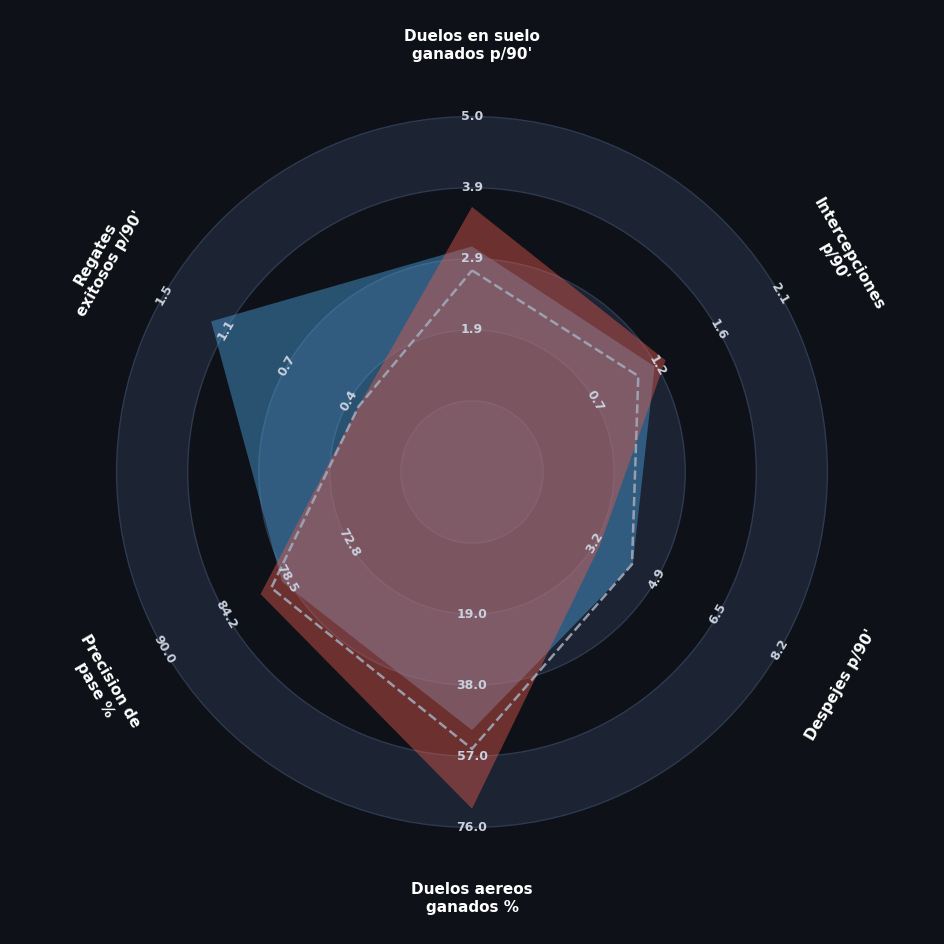

Saved -> outputs/Jeyson_Rojas_2026_radar_fans.png
Saved -> outputs/Jeyson_Rojas_2026_radar_fans_transparent.png


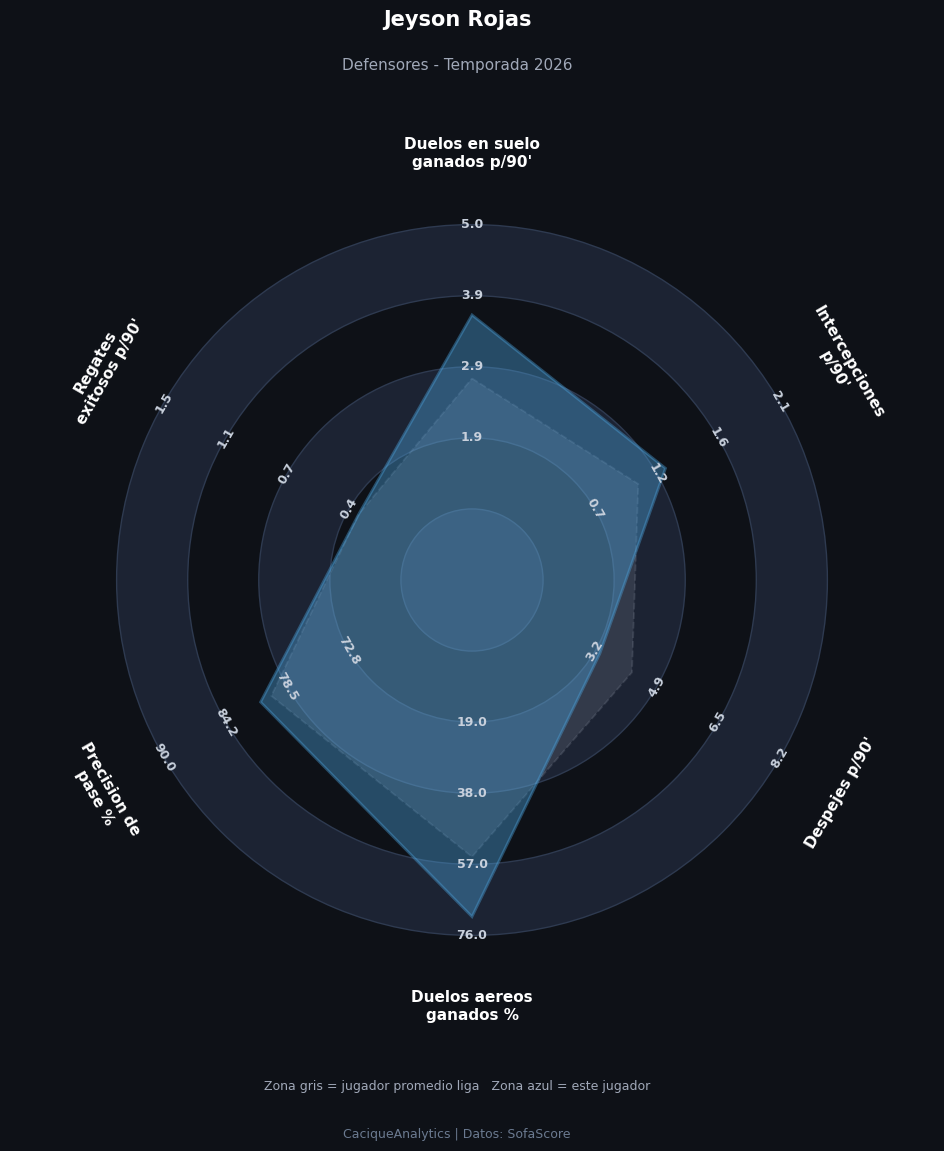

Saved -> outputs/Jeyson_Rojas_2026_radar_fans.png
Saved -> outputs/Jeyson_Rojas_2026_radar_fans_transparent.png


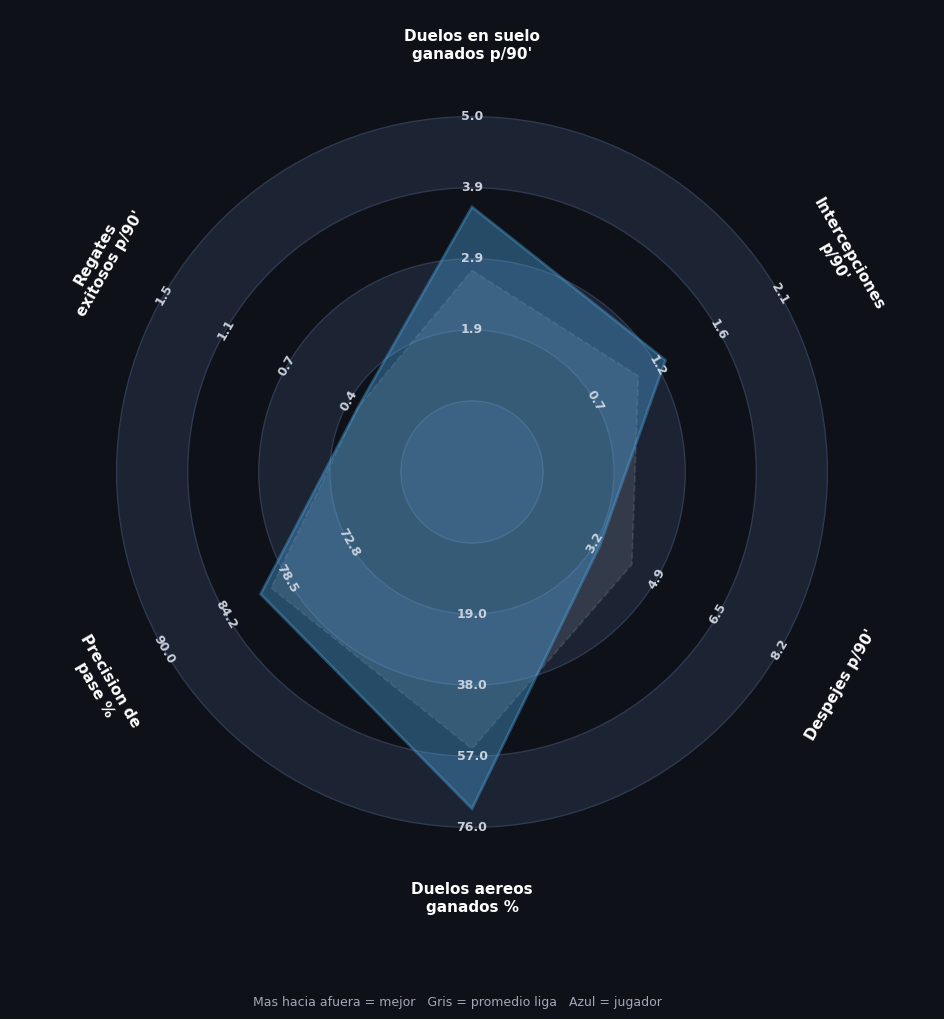

Saved -> outputs/Jeyson_Rojas_2026_bars.png
Saved -> outputs/Jeyson_Rojas_2026_bars_transparent.png


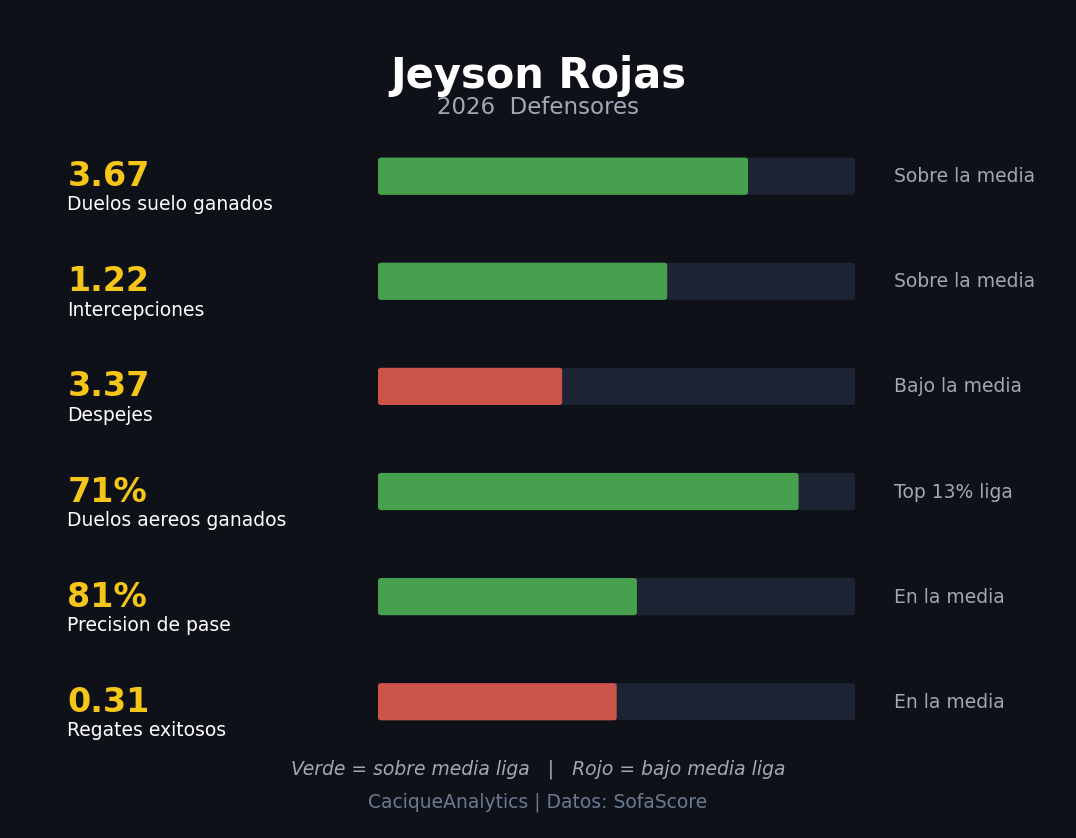

Saved -> outputs/Jeyson_Rojas_2026_infographic.png


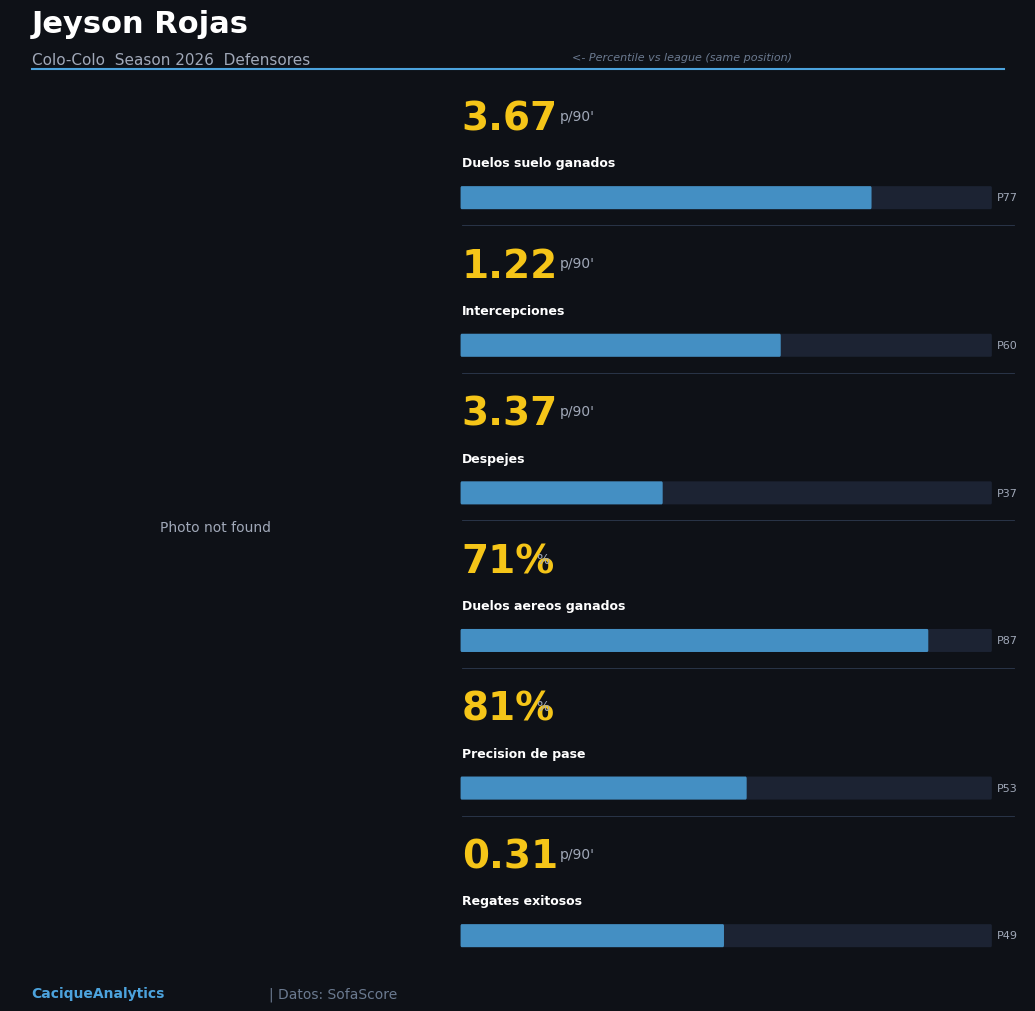

In [10]:
"""
Cell 10
Edit this cell to generate charts for a new player or post.
All chart functions are defined in the cells above.
"""

STATS_DEFENDERS = [
    ("groundDuelsWon_p90",       "Duelos suelo ganados",  "p/90'", False),
    ("interceptions_p90",        "Intercepciones",        "p/90'", False),
    ("clearances_p90",           "Despejes",              "p/90'", False),
    ("aerialDuelsWonPercentage", "Duelos aereos ganados", "%",     True),
    ("accuratePassesPercentage", "Precision de pase",     "%",     True),
    ("successfulDribbles_p90",   "Regates exitosos",      "p/90'", False),
]

PHOTO_ROJAS = r"C:\Users\PC\Projects\CaciqueAnalytics\assets\jeyson_rojas.jpg"

# Dual radar — full version with header and legend
build_radar("Jeyson Rojas", "2025", "Jeyson Rojas", "2026", "Defenders")

# Dual radar — polygon only for Photopea compositing
build_radar("Jeyson Rojas", "2025", "Jeyson Rojas", "2026", "Defenders", minimal=True)

# Fan-friendly radar — full version
build_radar_fan_friendly("Jeyson Rojas", "2026", "Defenders", minimal=False)

# Fan-friendly radar — minimal for Canva/Photopea
build_radar_fan_friendly("Jeyson Rojas", "2026", "Defenders", minimal=True)

# Horizontal percentile bars
build_performance_bars("Jeyson Rojas", "2026", "Defenders", STATS_DEFENDERS)

# Photo + stats infographic
build_infographic("Jeyson Rojas", "2026", "Defenders", PHOTO_ROJAS, STATS_DEFENDERS)

In [ ]:
# ── Run this cell as a standalone test script ──────────────────────────────
"""
Tests for utility functions in 03_visualization.ipynb.
Executed as a plain Python file; no pytest runner required inside the notebook.
All heavy imports (mplsoccer, PIL, matplotlib) are patched so the test file
can run even without a display / GPU.
"""

import sys
import types
import unittest
import numpy as np
import pandas as pd
from unittest.mock import MagicMock, patch

# ── 1. Stub out heavy optional dependencies before importing anything ───────
for mod_name in [
    "mplsoccer", "mplsoccer.Radar",
    "PIL", "PIL.Image",
    "matplotlib", "matplotlib.pyplot",
    "matplotlib.patches", "matplotlib.gridspec",
    "matplotlib.lines",
]:
    sys.modules.setdefault(mod_name, MagicMock())

# ── 2. Build a minimal module that exposes only the pure utility functions ──
#    We re-implement them here identically so the tests are self-contained
#    and do not require loading the full notebook kernel.

PCT_COLS = {
    "goalConversionPercentage",
    "accuratePassesPercentage",
    "accurateCrossesPercentage",
    "accurateLongBallsPercentage",
    "totalDuelsWonPercentage",
    "aerialDuelsWonPercentage",
    "groundDuelsWonPercentage",
}

INVERT_COLS = {
    "foulsCommitted_p90",
    "offsides_p90",
    "goalsConcededInsideTheBox_p90",
    "dribbledPast_p90",
}

# ── Minimal sample DataFrames ───────────────────────────────────────────────
_DEFENDERS_2026 = pd.DataFrame({
    "player":                    ["Jeyson Rojas", "Diego Valdés", "Carlos Palacios"],
    "position":                  ["Defenders"] * 3,
    "season":                    ["2026"] * 3,
    "groundDuelsWon_p90":        [3.67, 2.10, 4.50],
    "interceptions_p90":         [1.20, 0.80, 2.10],
    "clearances_p90":            [4.10, 3.00, 5.20],
    "aerialDuelsWonPercentage":  [71,   55,   62  ],
    "accuratePassesPercentage":  [81,   74,   69  ],
    "successfulDribbles_p90":    [0.50, 1.20, 0.30],
    "foulsCommitted_p90":        [1.10, 2.30, 0.90],
})

_DEFENDERS_2025 = pd.DataFrame({
    "player":                    ["Jeyson Rojas", "Pedro Fuentes"],
    "position":                  ["Defenders"] * 2,
    "season":                    ["2025"] * 2,
    "groundDuelsWon_p90":        [3.10, 2.80],
    "interceptions_p90":         [1.00, 1.50],
    "clearances_p90":            [3.80, 4.60],
    "aerialDuelsWonPercentage":  [68,   60  ],
    "accuratePassesPercentage":  [78,   72  ],
    "successfulDribbles_p90":    [0.40, 0.60],
    "foulsCommitted_p90":        [1.30, 1.80],
})

df_2026 = _DEFENDERS_2026
df_2025 = _DEFENDERS_2025


# ── Pure utility functions (copied verbatim from 03_visualization) ──────────

def get_player(df: pd.DataFrame, name: str):
    result = df[df["player"].str.lower() == name.lower()]
    if result.empty:
        return None
    return result.iloc[0]


def _fmt(val, metric: str):
    return int(round(val)) if metric in PCT_COLS else round(float(val), 2)


def _get_pool(position: str) -> pd.DataFrame:
    return pd.concat([
        df_2026[df_2026["position"] == position],
        df_2025[df_2025["position"] == position],
    ])


def _get_scale(pool: pd.DataFrame, metrics: list):
    low    = [_fmt(pool[m].quantile(0.05), m) for m in metrics]
    high   = [_fmt(pool[m].quantile(0.95), m) for m in metrics]
    median = [_fmt(pool[m].median(),        m) for m in metrics]
    return low, high, median


def _invert(metrics: list, low: list, high: list, *val_lists):
    for i, m in enumerate(metrics):
        if m in INVERT_COLS:
            lo, hi = low[i], high[i]
            for lst in val_lists:
                lst[i] = round(lo + hi - lst[i], 2)


# ═══════════════════════════════════════════════════════════════════════════
#  TEST SUITE
# ═══════════════════════════════════════════════════════════════════════════

class TestGetPlayer(unittest.TestCase):

    def test_found_exact(self):
        row = get_player(df_2026, "Jeyson Rojas")
        self.assertIsNotNone(row)
        self.assertEqual(row["player"], "Jeyson Rojas")

    def test_found_case_insensitive(self):
        row = get_player(df_2026, "jeyson rojas")
        self.assertIsNotNone(row)
        self.assertEqual(row["player"], "Jeyson Rojas")

    def test_found_uppercase(self):
        row = get_player(df_2026, "JEYSON ROJAS")
        self.assertIsNotNone(row)

    def test_not_found_returns_none(self):
        row = get_player(df_2026, "Lionel Messi")
        self.assertIsNone(row)

    def test_returns_first_row_when_duplicate(self):
        df_dup = pd.concat([df_2026, df_2026], ignore_index=True)
        row = get_player(df_dup, "Jeyson Rojas")
        self.assertIsNotNone(row)
        self.assertEqual(row["player"], "Jeyson Rojas")


class TestFmt(unittest.TestCase):

    def test_pct_col_returns_int(self):
        result = _fmt(71.4, "aerialDuelsWonPercentage")
        self.assertIsInstance(result, int)
        self.assertEqual(result, 71)

    def test_pct_col_rounds_up(self):
        result = _fmt(71.6, "aerialDuelsWonPercentage")
        self.assertEqual(result, 72)

    def test_non_pct_col_returns_float(self):
        result = _fmt(3.678, "groundDuelsWon_p90")
        self.assertIsInstance(result, float)
        self.assertEqual(result, 3.68)

    def test_non_pct_col_two_decimals(self):
        result = _fmt(1.005, "interceptions_p90")
        self.assertAlmostEqual(result, round(1.005, 2), places=5)

    def test_integer_input_pct(self):
        result = _fmt(80, "accuratePassesPercentage")
        self.assertEqual(result, 80)
        self.assertIsInstance(result, int)


class TestGetPool(unittest.TestCase):

    def test_pool_contains_both_seasons(self):
        pool = _get_pool("Defenders")
        self.assertEqual(len(pool), len(_DEFENDERS_2026) + len(_DEFENDERS_2025))

    def test_pool_only_target_position(self):
        pool = _get_pool("Defenders")
        self.assertTrue((pool["position"] == "Defenders").all())

    def test_pool_unknown_position_empty(self):
        pool = _get_pool("Aliens")
        self.assertTrue(pool.empty)


class TestGetScale(unittest.TestCase):

    def setUp(self):
        self.pool    = _get_pool("Defenders")
        self.metrics = ["groundDuelsWon_p90", "aerialDuelsWonPercentage"]

    def test_returns_three_lists(self):
        low, high, median = _get_scale(self.pool, self.metrics)
        self.assertEqual(len(low), 2)
        self.assertEqual(len(high), 2)
        self.assertEqual(len(median), 2)

    def test_low_leq_median_leq_high(self):
        low, high, median = _get_scale(self.pool, self.metrics)
        for lo, med, hi in zip(low, median, high):
            self.assertLessEqual(lo,  med)
            self.assertLessEqual(med, hi)

    def test_pct_col_values_are_int(self):
        low, high, median = _get_scale(self.pool, self.metrics)
        # index 1 is aerialDuelsWonPercentage → PCT_COL
        self.assertIsInstance(low[1],    int)
        self.assertIsInstance(high[1],   int)
        self.assertIsInstance(median[1], int)

    def test_non_pct_col_values_are_float(self):
        low, high, median = _get_scale(self.pool, self.metrics)
        # index 0 is groundDuelsWon_p90 → not PCT_COL
        self.assertIsInstance(low[0],    float)
        self.assertIsInstance(high[0],   float)
        self.assertIsInstance(median[0], float)


class TestInvert(unittest.TestCase):

    def test_invert_col_is_flipped(self):
        metrics = ["foulsCommitted_p90"]
        low     = [0.5]
        high    = [3.0]
        vals    = [1.2]
        _invert(metrics, low, high, vals)
        # expected: 0.5 + 3.0 - 1.2 = 2.3
        self.assertAlmostEqual(vals[0], 2.3, places=5)

    def test_non_invert_col_unchanged(self):
        metrics = ["groundDuelsWon_p90"]
        low     = [1.0]
        high    = [5.0]
        vals    = [3.67]
        _invert(metrics, low, high, vals)
        self.assertAlmostEqual(vals[0], 3.67, places=5)

    def test_multiple_lists_all_inverted(self):
        metrics = ["offsides_p90"]
        low     = [0.0]
        high    = [2.0]
        vals1   = [0.5]
        vals2   = [1.0]
        _invert(metrics, low, high, vals1, vals2)
        self.assertAlmostEqual(vals1[0], 1.5, places=5)
        self.assertAlmostEqual(vals2[0], 1.0, places=5)

    def test_mixed_metrics_partial_invert(self):
        metrics = ["groundDuelsWon_p90", "foulsCommitted_p90"]
        low     = [1.0, 0.5]
        high    = [5.0, 3.0]
        vals    = [3.67, 1.2]
        _invert(metrics, low, high, vals)
        self.assertAlmostEqual(vals[0], 3.67, places=5)   # unchanged
        self.assertAlmostEqual(vals[1], 2.3,  places=5)   # inverted


# ── Run all tests ────────────────────────────────────────────────────────────
loader = unittest.TestLoader()
suite  = unittest.TestSuite()

for cls in [TestGetPlayer, TestFmt, TestGetPool, TestGetScale, TestInvert]:
    suite.addTests(loader.loadTestsFromTestCase(cls))

runner = unittest.TextTestRunner(verbosity=2)
result = runner.run(suite)

if result.wasSuccessful():
    print("\n✅  All tests passed.")
else:
    print(f"\n❌  {len(result.failures)} failure(s), {len(result.errors)} error(s).")